# Data Drift Detection

The current notebook implements data drift detection on a dataset having motion sense data of a smart watch. The reference series is the attitude.roll value of the Subject 1 but over different type of movements like jogging,standing etc. The test series is an artifically created dataset where we combine the values of a similar dataset of subject 10 after 2500 data points.

## Code Implementation

In [1]:
import warnings
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from evidently.calculations.stattests import jensenshannon_stat_test
from evidently.calculations.stattests import kl_div_stat_test
from evidently.calculations.stattests import ks_stat_test
from evidently.calculations.stattests import psi_stat_test
from evidently.calculations.stattests import wasserstein_stat_test
from sklearn.metrics import confusion_matrix
import multiprocess

from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

def return_drift(ref: pd.Series, curr: pd.Series):
    """
    Summary: Returns the statistical difference between population of ref and curr

    Input: 
    ref:- Reference serie based on historical data
    curr:- Test series to be compared with

    Output: Series with the stats scores of different tests
    """

    report = pd.DataFrame(columns=['stat_test', 'drift_score', 'is_drifted'])
    for i, (stattest, threshold) in enumerate(
        zip([ks_stat_test, psi_stat_test, kl_div_stat_test, jensenshannon_stat_test, wasserstein_stat_test],
            [0.05, 0.1, 0.1, 0.1, 0.1])):
        report.loc[i, 'stat_test'] = stattest.display_name
        report.loc[i, 'drift_score'], report.loc[i, 'is_drifted'] = \
        stattest.func(ref, curr, 'num', threshold)
    return report['drift_score']

def add_new_drift(curr_new: pd.Series, drift_size: float, start_index: int,
                  stop_index:int,drift_mode :str= "0-shift"):
    
    """
    Summary:- Adds drift by displacing the values by a certain scale of the standard deviation
    of the data

    Input: 
    curr_new :- Series where the drift has to be introduced
    drift_size :- Scale of drift to be added
    start_index :- Start index in the series where drift has to be added
    stop_index :- End index in the series where drift has to be added
    drift_mode :- Mode of drift addition - i.e max 1 std, 2 std etc

    Output:
    Series with the drift added
    """

    drift_interval = (stop_index - start_index) 
    curr_df = curr_new.copy()
    
    col_names  = list(curr_df.columns)
    
    for curr_col in col_names:
        
        curr = curr_df[curr_col]
        if drift_mode=="0-shift":
            ## Shifting the data with a scale of norm(0) * std(data)
            drift_curr = (np.random.normal(0,1,drift_interval))*drift_size*np.std(curr)
        elif drift_mode == '2-shift':
            ## Shifting the data with a scale of norm(2) * std(data)
            drift_curr = (np.random.normal(2,1,drift_interval))*drift_size*np.std(curr)
        else:
            ## Shifting the data with a scale of norm(1) * std(data)
            drift_curr = (np.random.normal(1,1,drift_interval))*drift_size*np.std(curr)
    
        curr[start_index:stop_index] = curr[start_index:stop_index] + drift_curr
        curr_df[curr_col] = curr
    
    return curr_df


def create_test_set(df_jog1: pd.DataFrame,size_limit = 100000) -> tuple:

    """
    Summary: Creates a test dataset by adding synthetic drift

    Input:
    df_jog1 :- Dataframe on to which drift is added

    Output:
    Tuple of the following
    df_jog_shifted :- Series with drift added to it
    df_jog :- Input series to act as reference
    bin_indi :- Series with binary indicators of drift (1) or not
    """

    df_jog = pd.DataFrame()

    ## Replicating the dataframe num_iter times
    df_size = df_jog1.shape[0]

    if(df_size> size_limit):
        df_jog = df_jog1[:size_limit].copy()
    else:
        while(df_size < size_limit):
            df_jog = pd.concat([df_jog,df_jog1])
            df_size = df_jog.shape[0]

    df_jog.reset_index(drop=True,inplace=True)

    ## Generating the drift intervals

    start_index = 0
    stop_index = 0
    N_max = df_jog.shape[0] 
    interval_num = 1 ## Counter on number of intervals where drift was added

    """
    Parameters:

    interval_lambda :- The interval between each drift window is separated is
    exponential distributed. The variable indicates the lambda value of the 
    distribution

    drift_size :- Scale of drift to be added

    size_mean :- The length of each drift window is normally distributed. 
    This variable indicates the mean of the this distribution

    size_std :- The length of each drift window is normally distributed. 
    This variable indicates the std of the this distribution
    """

    interval_lambda = 2000 
    drift_size = 0.9
    size_mean = 1000
    size_std = 50

    curr_interval = int(np.random.exponential(scale = interval_lambda,size=1))
    curr_size = int(np.random.normal(size_mean,size_std,1))

    start_index = start_index + curr_interval ## Start index of next drift window
    stop_index = start_index + curr_size ## Stop index of next drift window

    ## Adding zeroes to indicate no drift 
    bin_indi = np.zeros(curr_interval) 
    ## Adding ones to indicate drift occured for a window of curr size
    bin_indi = np.concatenate([bin_indi,np.ones(curr_size)]) 

    ## Adding drift to the series based on start and end index
    df_jog_shifted = add_new_drift( df_jog,drift_size=drift_size,start_index=start_index,
                                stop_index=stop_index,drift_mode="2-shift")

    ## Obtaining the next set of window
    curr_interval = int(np.random.exponential(scale = interval_lambda,size=1))
    curr_size = int(np.random.normal(size_mean,size_std,1))


    start_index = stop_index + curr_interval
    stop_index = start_index + curr_size

    while(stop_index<=N_max): ## Iterating till we reach the end of series

        ## Adding zeroes to indicate no drift from end of curr window till start of next window
        bin_indi = np.concatenate([bin_indi,np.zeros(curr_interval)])
        ##Adding ones to indicate drift occured for a window of curr size
        bin_indi = np.concatenate([bin_indi,np.ones(curr_size)])

        interval_num+=1
        df_jog_shifted = add_new_drift(df_jog_shifted,drift_size=drift_size,start_index=start_index,
                                    stop_index=stop_index,drift_mode="0-shift")

        ## Updating the start and end index with new values
        curr_interval = int(np.random.exponential(scale = interval_lambda,size=1))
        curr_size = int(np.random.normal(size_mean,size_std,1))

        start_index = stop_index + curr_interval
        stop_index = start_index + curr_size

    ## To offset the end of the indicator values with zeros to indicate no drift
    offset_val = (df_jog_shifted.shape[0]) - len(bin_indi)
    bin_indi = np.concatenate([bin_indi,np.zeros(offset_val)])

    return (df_jog_shifted,df_jog,bin_indi)


def return_optimum_window_size(main_series: pd.Series) -> int:

    """
    Summary: Function to find the optimum window size for implementing data drift detection.
    A Bayesian optimizer is used to find the window size with the maximum accuracy by adding random
    drift in the reference data and calculating accuracy with respect to the data.

    Input: 
    main_series:- Reference series to be tested for optimum window size

    Output:
    Window size
    """

    size_limit = 100000 ## Maximum size of the test series
    main_df = pd.DataFrame(main_series)
    
    ## Creating the synthetic series for finding the optimum window size 
    (drifted_df,ref_df,bin_indi) = create_test_set(main_df,size_limit)
    
    curr_test  = drifted_df.iloc[:,0] ## Test data
    ref_total  = ref_df.iloc[:,0] ## Reference data to detect drift
    curr_indi  = pd.DataFrame({"indi":bin_indi}).iloc[:,0] ## Binary indicators on drift 

    curr_test = curr_test.reset_index(drop=True) 


    def check_drift_accuracy(N_arr: float) -> float:

        """
        Summary: Function to return the accuracy on the drift data when window size of N_arr is used
        
        Input: Current window size

        Output:
        Accuracy measure
        """
    
        N = int(N_arr*100) # Since window size must be an integer

        curr_buff = curr_test[:N]
        chunk_size= 200  ## Current chunk size

        ## To feed the data in chunks
        curr_start = N
        curr_end = N+chunk_size

        end_data = size_limit 
        curr_t = N

        result_pd = pd.DataFrame() ## Dataframe where the results of the stats tests will be stored
        fun_name = [ks_stat_test, psi_stat_test, kl_div_stat_test, jensenshannon_stat_test, wasserstein_stat_test]
        test_names = [each_test.display_name for each_test in fun_name]
        result_pd['Test'] = test_names

        ## To obtain the reference series
        curr_ref = ref_total[:]

        ## Iterating on the different chunks
        while(curr_end <= end_data ):

            curr_res = return_drift(curr_ref, curr_buff) ## Getting the stats scores
            result_pd['t=' + str(curr_t)] = curr_res

            ## Importing the new chunk
            curr_start = curr_start + chunk_size 
            curr_end = curr_end + chunk_size
            curr_chunk = curr_test[curr_start:curr_end]

            curr_buff = curr_buff[chunk_size:]
            curr_buff = pd.concat([curr_buff,curr_chunk])
            curr_t = curr_t + chunk_size

        result_pd = result_pd.T 

        result_pd.columns = result_pd.iloc[0]
        result_pd.drop(result_pd.index[0],inplace=True)
        result_pd.reset_index(drop=False,inplace=True)

        result_pd_2  = result_pd.copy()
        for each_test in test_names:
            result_pd_2[each_test] = result_pd_2[each_test].astype('float') ## Final result dataframe

        index_col = np.arange(start=N,stop=end_data,step=chunk_size)

        indi_column = curr_indi[index_col].reset_index(drop=True) ## Getting the correct indices

        result_pd_2['Correct_mark'] = indi_column 

        ## Set thresholds for determing the drift accuracy for different metrics
        PSI_threshold = 3
        JS_threshhold = 0.5
        KL_Div_threshold = 2

        ## Checking whether drift occured based on each statistical measure
        result_pd_2['PSI_drift'] = np.where(result_pd_2['PSI']>PSI_threshold,1,0)
        result_pd_2['JS_drift'] = np.where(result_pd_2['Jensen-Shannon distance']>JS_threshhold,1,0)
        result_pd_2['KL_drift'] = np.where(result_pd_2['Kullback-Leibler divergence']>KL_Div_threshold,1,0)

        ## Obtaining the accuracy measures
        tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['PSI_drift'],labels=[0,1]).ravel()
        summary_pd = pd.DataFrame({"Test":["PSI"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})
        tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['JS_drift'],labels=[0,1]).ravel()
        summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["JS"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])
        tn, fp, fn, tp = confusion_matrix(result_pd_2['Correct_mark'],result_pd_2['KL_drift'],labels=[0,1]).ravel()
        summary_pd = pd.concat([summary_pd,pd.DataFrame({"Test":["KL_div"],"TN":[tn],"FP":[fp],"FN":[fn],"TP":[tp]})])

        summary_pd['Accuracy'] = (summary_pd['TP'] + summary_pd['TN'])/summary_pd.sum(axis=1,numeric_only=True)
        summary_pd['Precision'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FP'])
        summary_pd['Recall'] = (summary_pd['TP'])/(summary_pd['TP'] + summary_pd['FN'])

        return_val = summary_pd['Accuracy'] ## The accuracy is chosen as the return metric

        ## We only report the accuracy only if drift is reported for atleast one point
        tp_count = int(sum(summary_pd['TP'])) 
        if tp_count==0:
            return 0

        return int(sum(return_val*100))

    ##########################################################################
    ##   Optimization implementation using the above function               ##
    ##########################################################################
    

    start = time.time()

    global_res = []

    def bayesian_optimiser(start_val: int, end_val: int) -> dict:

        """
        Inputs:
        start_val :- lower bound of search space
        end_val :- upper bound of search space

        Summary: Obtains the window size producing the maximum drift accuracy 
        in the provided search space

        Outputs:
        Dictionary with optimum window and its accuracy
        """

        pbounds = {'N_arr':(start_val,end_val)}
        bounds_transformer = SequentialDomainReductionTransformer(minimum_window=0.5)

        optimizer = BayesianOptimization(
            f=check_drift_accuracy,
            pbounds=pbounds, ## bounds for search
            verbose=0, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
            random_state=5, ## random state
            bounds_transformer= bounds_transformer, ## inbuilt function which shrinks the search space
            allow_duplicate_points=True ## allowing same value to be repeated
        )

        optimizer.maximize(init_points=5,n_iter=50) ## n_iter = no of iterations
        res_dict = {}
        res_dict['Window'] = int(optimizer.max['params']['N_arr']*100)
        res_dict['Accuracy'] = optimizer.max['target']

        return res_dict
    
    ## Ranges of window sizes
    para_list = [(1,20),(21,40),(41,60),(61,80),(81,100)]

    ## Implementing multiprocessing with 5 processors
    with multiprocess.Pool(5) as p:
        global_res += p.starmap(bayesian_optimiser,para_list)

    stop = time.time()
    
    total_time = (stop - start)/60
    print(f'Time taken for optimziation is {total_time}') ## Time taken
    
    
    ### Finding the best window size out of all bounds   
    curr_max = -1
    curr_window = 0
    
    for each_window in global_res:
        if(each_window['Accuracy']>curr_max):
            curr_window = each_window['Window']
            curr_max = each_window['Accuracy']
        
    print(f'The optimum window size is {curr_window} and accuracy is {curr_max}')
    
    return curr_window
    
    

In [2]:

import pandas as pd
import numpy as np

from evidently.calculations.stattests import jensenshannon_stat_test
from evidently.calculations.stattests import kl_div_stat_test
from evidently.calculations.stattests import ks_stat_test
from evidently.calculations.stattests import psi_stat_test
from evidently.calculations.stattests import wasserstein_stat_test

def return_drift(ref: pd.Series, curr: pd.Series):
    """
    Summary: Returns the statistical difference between population of ref and curr

    Input: 
    ref:- Reference serie based on historical data
    curr:- Test series to be compared with

    Output: Series with the stats scores of different tests
    """

    report = pd.DataFrame(columns=['stat_test', 'drift_score', 'is_drifted'])
    for i, (stattest, threshold) in enumerate(
        zip([ks_stat_test, psi_stat_test, kl_div_stat_test, jensenshannon_stat_test, wasserstein_stat_test],
            [0.05, 0.1, 0.1, 0.1, 0.1])):
        report.loc[i, 'stat_test'] = stattest.display_name
        report.loc[i, 'drift_score'], report.loc[i, 'is_drifted'] = \
        stattest.func(ref, curr, 'num', threshold)
    return report['drift_score']


def return_drift_indicator(curr_ref: pd.Series, curr_buff: pd.Series, return_dataframe=False):
        
    """
    Summary: Checks for drift between reference and test series

    Input:
    curr_ref :- The reference series
    curr_buff :- Current test series
    return_dataframe :- Boolean variable indicating whether to return the results dataframe

    Output:
    curr_result :- Indicator denoting whether there is a drift or not
    curr_result :- Results dataframe with stats test values and individual indicators
    """
    
    fun_name = [ks_stat_test, psi_stat_test, kl_div_stat_test, jensenshannon_stat_test, wasserstein_stat_test]
    test_names = [each_test.display_name for each_test in fun_name]

    ## Thersholds for each test
    PSI_threshold = 3
    JS_threshhold = 0.5
    KL_Div_threshold = 2
    overall_threshold = 0.5

    curr_t = 1

    ## Result dataframe with stats test values
    curr_res = return_drift(curr_ref, curr_buff)

    ## Curr_value
    curr_check = pd.DataFrame()
    curr_check['Test'] = test_names
    curr_check['t=' + str(curr_t)] = curr_res

    curr_check = curr_check.T
    curr_check.columns = curr_check.iloc[0]
    curr_check.drop(curr_check.index[0],inplace=True)
    curr_check.reset_index(drop=False,inplace=True)

    ## Checking if there is a drift based on individual and test values 
    curr_check['PSI_drift'] = np.where(curr_check['PSI']>PSI_threshold,1,0)
    curr_check['JS_drift'] = np.where(curr_check['Jensen-Shannon distance']>JS_threshhold,1,0)
    curr_check['KL_drift'] = np.where(curr_check['Kullback-Leibler divergence']>KL_Div_threshold,1,0)

    ## Considering weighted results of tests and getting the overall result
    curr_check['Overall_drift'] = np.where(((0.4*curr_check['PSI_drift']+
                                              0.4*curr_check['JS_drift']+
                                              0.2*curr_check['KL_drift']))>overall_threshold,1,0)

    curr_result = curr_check['Overall_drift'][0]

    if return_dataframe:
        return (curr_result,curr_check)
    else:
        return curr_result


The code has been slightly modified to account for running in a jupyter notebook. But the results will be the same.

In [3]:
import time
import argparse
import csv
import sys
import yaml
import pandas as pd

## Reference and test data
folder_location = '/Users/kiranjyothisheena/Documents/Kiran_Files/CDL_Practicum/Datasets/Motion_Sense/Test_datasets/'

subject_1 = pd.read_csv(folder_location + 'Subject_1_random.csv')
ref_total = subject_1['attitude.roll']



## Obtaining the optimum window size
max_window = return_optimum_window_size(ref_total)

chunk_size = 1 ## Chunk size with which data is fed in
## Maximum consecutive data points after which drift is alarmed
max_threshold = 40
curr_threshold_check = 0 ## Counter for checking consecutive points

result_pd = pd.DataFrame()
return_dataframe = True ## Boolean to decide if results need to be returned (For debug only)

curr_buff = pd.Series() ## Dataframe to hold the test values

## Helper function to simulate streaming using csv values
def stream_csv_data(filename):
    """
    Summary: Function to simulate streaming data

    Input:
    filename: Name of csv file
    """
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        headers = next(reader)  # Read the header row
        for row in reader:
            yield dict(zip(headers, row))
            time.sleep(0.5)  # Simulate a delay of 0.5 second between each row

## Test data
csv_filename = folder_location + 'Subject_1_10_Sudden_Drift.csv'

curr_t = max_window
for data_row in stream_csv_data(csv_filename):
    curr_value = float(data_row['attitude.roll']) ## Reading the new value

    ## Checking if curr buffer size is less than window
    ## If yes, we fill the buffer else we test for drift
    if len(curr_buff) < max_window:
        curr_buff = pd.concat([curr_buff,pd.Series(curr_value)])
    else:
        if return_dataframe:
            curr_result,curr_res_dataframe = \
            return_drift_indicator(curr_buff,ref_total,return_dataframe)    
        else:
            curr_result = \
                return_drift_indicator(curr_buff,ref_total,return_dataframe)

        if curr_result==1:
            curr_threshold_check+=1 ## Increasing the counter if we detect drift
        else:
            curr_threshold_check = 0

        if curr_threshold_check > max_threshold:
            print('Drift Detected')
            break

        ## Updating the buffer
        curr_buff = curr_buff[chunk_size:]
        curr_buff = pd.concat([curr_buff,pd.Series(curr_value)])

        if return_dataframe:
            curr_res_dataframe['index'] = 't=' + str(curr_t)
            curr_t += 1
            result_pd = pd.concat([result_pd,curr_res_dataframe])


Data point [20.] is not unique. 1 duplicates registered. Continuing ...
Data point [20.] is not unique. 2 duplicates registered. Continuing ...
Data point [20.] is not unique. 3 duplicates registered. Continuing ...
Data point [20.] is not unique. 4 duplicates registered. Continuing ...
Data point [20.] is not unique. 5 duplicates registered. Continuing ...
Data point [20.] is not unique. 6 duplicates registered. Continuing ...
Data point [20.] is not unique. 7 duplicates registered. Continuing ...
Data point [40.] is not unique. 1 duplicates registered. Continuing ...
Data point [20.] is not unique. 8 duplicates registered. Continuing ...
Data point [40.] is not unique. 2 duplicates registered. Continuing ...
Data point [20.] is not unique. 9 duplicates registered. Continuing ...
Data point [40.] is not unique. 3 duplicates registered. Continuing ...
Data point [20.] is not unique. 10 duplicates registered. Continuing ...
Data point [40.] is not unique. 4 duplicates registered. Contin

/var/folders/hn/4swgrrzj36vd9rq1mqmr39j80000gn/T/ipykernel_12781/455397472.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  curr_buff = pd.Series() ## Dataframe to hold the test values


Drift Detected


## Results

Text(0.5, 1.0, 'Reference Data')

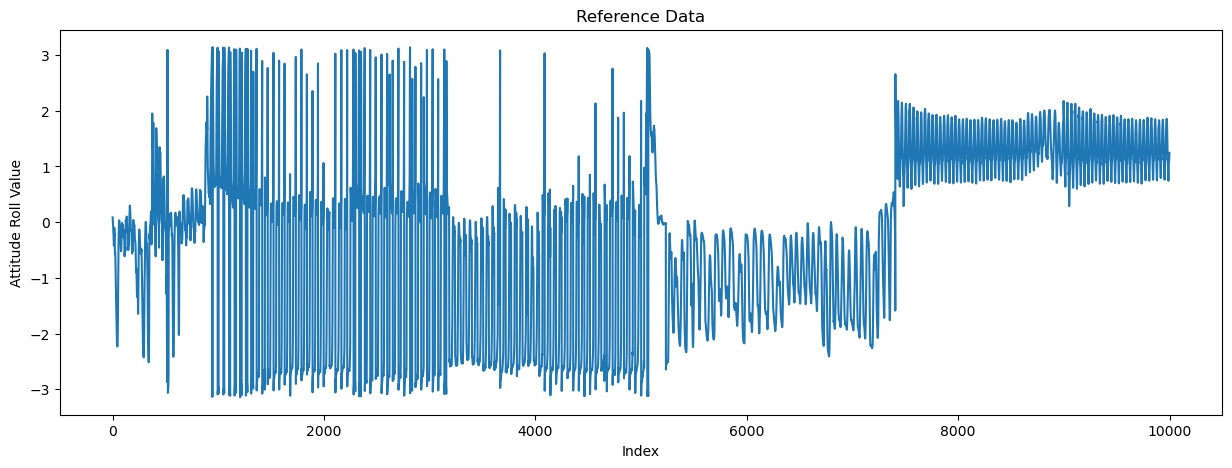

In [4]:
## Plotting the reference series

fig,ax = plt.subplots(figsize=(15,5))
plt.plot(ref_total[:10000])
plt.xlabel('Index')
plt.ylabel('Attitude Roll Value')
plt.title('Reference Data')

Text(0.5, 1.0, 'Test Data')

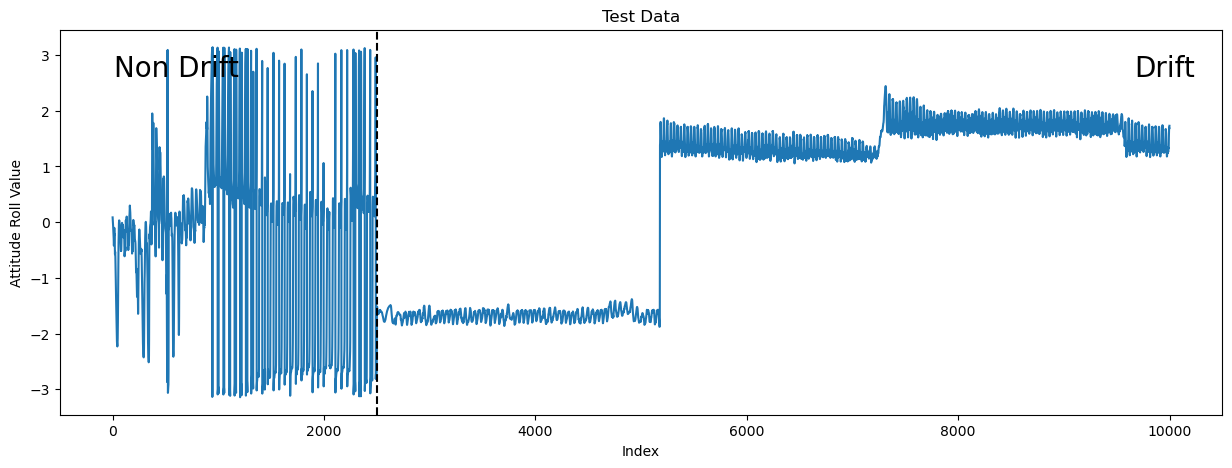

In [5]:
## Plotting the Test series

test_data = pd.read_csv(csv_filename)
test_data = test_data['attitude.roll']

fig,ax = plt.subplots(figsize=(15,5))
plt.plot(test_data[:10000])
plt.text(0.1, 0.9, 'Non Drift', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes,fontsize=20)
plt.text(0.95, 0.9, 'Drift', horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes,fontsize=20)
plt.axvline(x = 2500, color = 'black', label = 'Drift',ls='--')
plt.xlabel('Index')
plt.ylabel('Attitude Roll Value')
plt.title('Test Data')

In [11]:
result_pd[:50]

Test,index,K-S p_value,PSI,Kullback-Leibler divergence,Jensen-Shannon distance,Wasserstein distance (normed),PSI_drift,JS_drift,KL_drift,Overall_drift
index,,,,,,,,,,
t=6640,t=6640,0.0,2.5926,1.345975,0.490194,0.794352,0,0,0,0
t=6641,t=6641,0.0,2.592298,1.345816,0.490157,0.79411,0,0,0,0
t=6642,t=6642,0.0,2.592475,1.345948,0.490173,0.793871,0,0,0,0
t=6643,t=6643,0.0,2.592652,1.34608,0.49019,0.793643,0,0,0,0
t=6644,t=6644,0.0,2.59283,1.346213,0.490207,0.79342,0,0,0,0
t=6645,t=6645,0.0,2.593009,1.346346,0.490224,0.79321,0,0,0,0
t=6646,t=6646,0.0,2.593188,1.34648,0.490241,0.793009,0,0,0,0
t=6647,t=6647,0.0,2.593368,1.346614,0.490259,0.792806,0,0,0,0
t=6648,t=6648,0.0,2.593549,1.346749,0.490276,0.792598,0,0,0,0


In [12]:
result_pd[-50:]

Test,index,K-S p_value,PSI,Kullback-Leibler divergence,Jensen-Shannon distance,Wasserstein distance (normed),PSI_drift,JS_drift,KL_drift,Overall_drift
index,,,,,,,,,,
t=8179,t=8179,0.0,2.995824,1.545217,0.535293,0.523673,0,1,0,0
t=8180,t=8180,0.0,2.995949,1.545288,0.535307,0.523531,0,1,0,0
t=8181,t=8181,0.0,2.996075,1.54536,0.535322,0.523389,0,1,0,0
t=8182,t=8182,0.0,2.996202,1.545433,0.535336,0.523247,0,1,0,0
t=8183,t=8183,0.0,2.99633,1.545506,0.535351,0.523109,0,1,0,0
t=8184,t=8184,0.0,2.996459,1.54558,0.535365,0.522969,0,1,0,0
t=8185,t=8185,0.0,2.99659,1.545655,0.53538,0.522822,0,1,0,0
t=8186,t=8186,0.0,2.996721,1.54573,0.535395,0.522666,0,1,0,0
t=8187,t=8187,0.0,2.996854,1.545805,0.53541,0.522529,0,1,0,0


The maximum threshold is kept as 40. Hence the algorithm reported drift after detecting 40 data points as drifted after t= 8189. We started from t = 6640 since the window size was 6640.

In [7]:
def plot_drift_graph(df_plot,sheet_name,x_diff):
    df_plot.index = df_plot['index']                      
    fix,ax = plt.subplots(figsize=(12,9))
    plt.plot(df_plot['PSI'],label='PSI')
    plt.plot(df_plot['Kullback-Leibler divergence'],label='Kullback-Leibler divergence')
    plt.plot(df_plot['Jensen-Shannon distance'],label='Jensen-Shannon distance')
    plt.xticks(df_plot.index[::x_diff],df_plot['index'][::x_diff],rotation=90)
    plt.yticks(range(15),range(15))
    plt.xlabel('Time',fontsize=15)
    plt.ylabel('Parameter Value',fontsize=15)
    plt.title(sheet_name,fontsize=15)
    plt.grid()
    plt.legend()

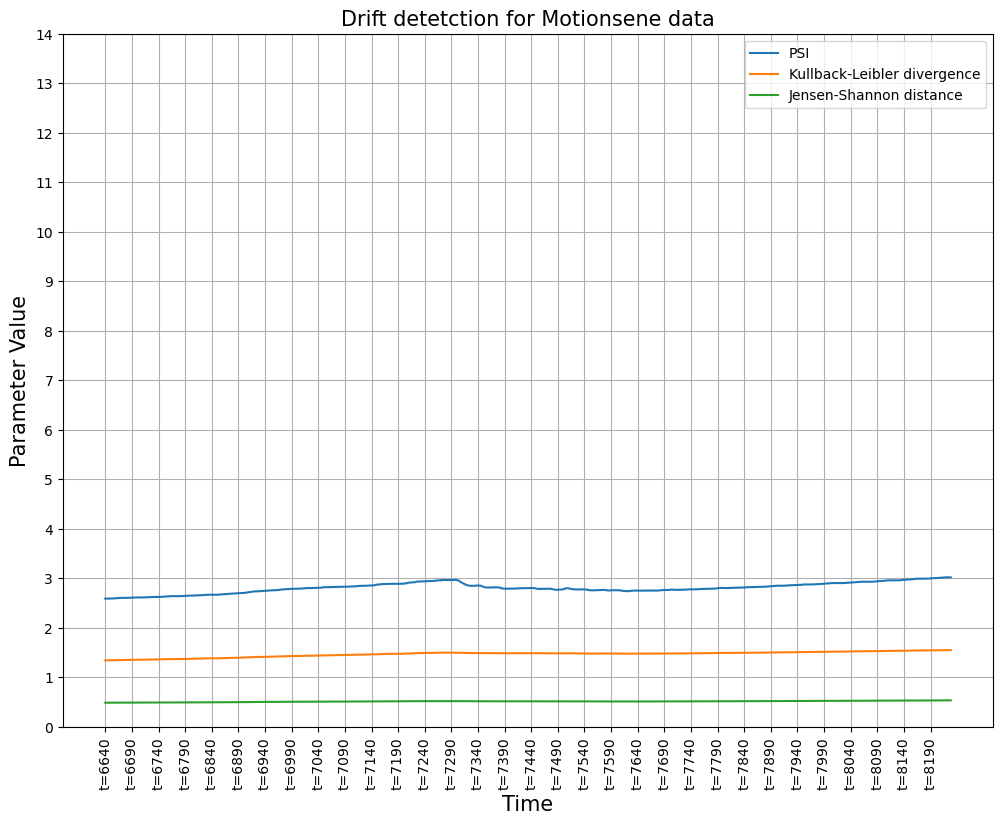

In [10]:
plot_drift_graph(result_pd,'Drift detetction for Motionsene data',50)

The above graph showcases the statistical values obtained over time. The values crosses the threshold after t=8189. It might have taken a longer time to detect drift maybe because the data had motion information about multiple movements including jogging,standing etc and was quite varied throughout eventhough it is only by a single subject. 